# Вступительное задание ЛШ 2017 DataScience 2017

## Задание 1

Импортируем всё необходимое и загрузим данные:

In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
import brewer2mpl
from sklearn import tree
from IPython.display import Image 
import pydotplus
from sklearn.ensemble import RandomForestClassifier

In [2]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.head()

,id,identifier,name,name_phonetic,species,name_jp,name_jp_romaji,species_jp,generation_id,ndex,...,exp_yield,base_happiness,egg_group1_id,egg_group2_id,is_baby,baby_breed_item_id,hatch_counter,lvl_100_exp,pokemon_order,legacy_id
0,1,bulbasaur,Bulbasaur,Bulbasaur,Seed,フシギダネ,Fushigidane,たね,1,1,...,64,70,1,7.0,0,NaN,20,1059860,1,1.0
1,2,ivysaur,Ivysaur,Ivysaur,Seed,フシギソウ,Fushigisou,たね,1,2,...,141,70,1,7.0,0,NaN,20,1059860,2,2.0
2,3,venusaur,Venusaur,Veenasore,Seed,フシギバナ,Fushigibana,たね,1,3,...,208,70,1,7.0,0,NaN,20,1059860,3,3.0
3,4,charmander,Charmander,Char-mander,Lizard,ヒトカゲ,Hitokage,とかげ,1,4,...,65,70,1,14.0,0,NaN,20,1059860,4,4.0
4,5,charmeleon,Charmeleon,Char-meeleon,Flame,リザード,Lizardo,かえん,1,5,...,142,70,1,14.0,0,NaN,20,1059860,5,5.0


## Первичный анализ и подготовка данных

Посмотрим на размер данных, признаки и типы переменных:

In [3]:
print(pokemon.shape) # Всего данные содержат информацию о 663 объектах и 38 признаках для них

(663, 38)


In [4]:
print(pokemon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 38 columns):
id                             663 non-null int64
identifier                     663 non-null object
name                           663 non-null object
name_phonetic                  663 non-null object
species                        663 non-null object
name_jp                        663 non-null object
name_jp_romaji                 663 non-null object
species_jp                     663 non-null object
generation_id                  663 non-null int64
ndex                           663 non-null int64
kdex                           151 non-null float64
jdex                           256 non-null float64
jdex_old                       251 non-null float64
hdex                           205 non-null float64
sdex                           218 non-null float64
udex                           158 non-null float64
type1_id                       663 non-null int64
type2_id                  

Многие переменные содержат пропущенные значения, также некоторые из признаков практически дублируют друг друга, избавимся от переменных, которые не несут дополнительной смысловой нагрузки или содержат с пропуски.

In [5]:
pokemon = pokemon.dropna(axis=1)
pokemon = pokemon.drop(['name_phonetic', 'identifier', 'name', 'name_jp', 'name_jp_romaji', 'species_jp', 'ndex', 'pokemon_order'], axis=1)
print(pokemon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 15 columns):
id                663 non-null int64
species           663 non-null object
generation_id     663 non-null int64
type1_id          663 non-null int64
ability1_id       663 non-null int64
height            663 non-null int64
weight            663 non-null int64
gender_rate       663 non-null int64
catch_rate        663 non-null int64
exp_yield         663 non-null int64
base_happiness    663 non-null int64
egg_group1_id     663 non-null int64
is_baby           663 non-null int64
hatch_counter     663 non-null int64
lvl_100_exp       663 non-null int64
dtypes: int64(14), object(1)
memory usage: 77.8+ KB
None


Осталось 15 признаков, из которых лишь один определён как "object".

In [6]:
pokemon.describe(include=['object'])

,species
count,663
unique,475
top,Dragon
freq,7


Переменная содержит 475 уникальных значений, среди которых наиболее часто (7 раз!) встречается значение "Dragon". Присвоим каждому из уникальных значений признака числовой код (от 0 до 474), чтобы в дальнейшем с данными можно было работать с использованием алгоритмов sklearn. Также извлечём данные из дополнительных файлов ("abilities.csv" и "egg_groups.csv") и объединим их с исходными.

In [7]:
le = LabelEncoder()
le.fit(pokemon.species)
pokemon['species_id'] = le.transform(pokemon.species)
pokemon['species'] = pokemon['species_id']
pokemon = pokemon.drop(['species_id'], axis=1)

abilities = pd.read_csv('abilities.csv')
a_col = list()
b_col = list()
for val in pokemon["ability1_id"]:
    a_col.append(int(abilities.loc[abilities['id'] == val]["generation_id"]))
    b_col.append(int(abilities.loc[abilities['id'] == val]["color_id"]))
a_col_s = pd.Series(a_col)
b_col_s = pd.Series(b_col)
pokemon.insert(loc=5, column='ability_gen_id', value=a_col_s)
pokemon.insert(loc=6, column='ability_color_id', value=b_col_s)

egg_groups = pd.read_csv('egg_groups.csv')
col_egg = list()
for val in pokemon["egg_group1_id"]:
    col_egg.append(int(egg_groups.loc[egg_groups['id'] == val]['legacy_id']))
col_egg_plus = pd.Series(col_egg)
pokemon.insert(loc=14, column='egg_legacy', value=col_egg_plus)
pokemon.head()

,id,species,generation_id,type1_id,ability1_id,ability_gen_id,ability_color_id,height,weight,gender_rate,catch_rate,exp_yield,base_happiness,egg_group1_id,egg_legacy,is_baby,hatch_counter,lvl_100_exp
0,1,365,1,12,65,3,12,7,69,1,45,64,70,1,9,0,20,1059860
1,2,365,1,12,65,3,12,10,130,1,45,141,70,1,9,0,20,1059860
2,3,365,1,12,65,3,12,20,1000,1,45,208,70,1,9,0,20,1059860
3,4,248,1,10,66,3,10,6,85,1,45,65,70,1,9,0,20,1059860
4,5,158,1,10,66,3,10,11,190,1,45,142,70,1,9,0,20,1059860


В конечной выборке 18 признаков, найдём количество уникальных значений каждой переменной:

In [8]:
def find_categories(pokemon):
    for name in pokemon.columns:
        unic = pokemon[name].nunique()
        print name + ':', unic 
find_categories(pokemon)

id: 663
species: 475
generation_id: 5
type1_id: 17
ability1_id: 117
ability_gen_id: 3
ability_color_id: 24
height: 47
weight: 373
gender_rate: 7
catch_rate: 30
exp_yield: 186
base_happiness: 6
egg_group1_id: 15
egg_legacy: 15
is_baby: 2
hatch_counter: 10
lvl_100_exp: 6


Не считая первой переменной, содержащей id покемонов, количество уникальных значений остальных признаков гораздо меньше, чем число исследуемых объектов, это позволяет сделать вывод о том, что перед нами категориальные данные. 

## Визуальный анализ данных

Построим несколько пирожковых диаграмм, чтобы познакомиться со структурой данных и сделать некоторые выводы.

In [9]:
%pylab inline

dark2_colors = brewer2mpl.get_map('Dark2', 'Qualitative', 7).mpl_colors

rcParams['figure.figsize'] = (5, 4)
rcParams['figure.dpi'] = 100
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 12
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

Populating the interactive namespace from numpy and matplotlib


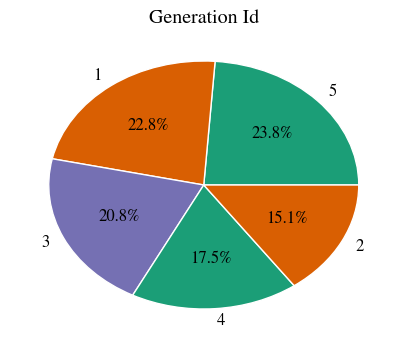

In [10]:
pokemon['generation_id'].value_counts().plot(kind='pie', label=' ', autopct='%1.1f%%', colors = dark2_colors[0:3]);
plt.title('Generation Id');

Почти половина из попавших в выборку покемонов являются представителями 1-го либо 5-го поколения (в равных долях), далее следует 3 поколение, на которое приходится 20% выборки, ко 2-му и 4-му поколению относится приблизительно по 16% покемонов.

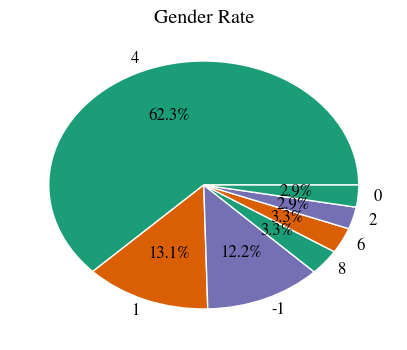

In [11]:
pokemon['gender_rate'].value_counts().plot(kind='pie', label=' ', autopct='%1.1f%%', colors = dark2_colors[0:3]);
plt.title('Gender Rate');

Большинство покемонов, а именно - 62,3%, относит себя к гендерному признаку под номером 4, а около 12,5% - к признакам под номерами 1 или -1. Доля покемонов, чья гендерная принадлежность определяется номерами 0, 2, 6 или 8, не превышает 3,5%. 

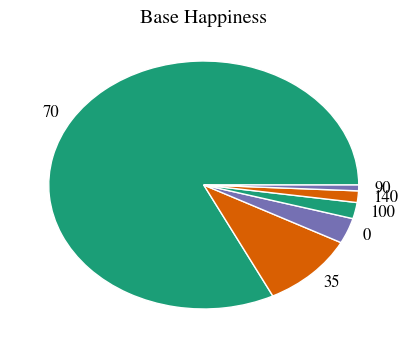

In [12]:
pokemon['base_happiness'].value_counts().plot(kind='pie', label=' ', colors = dark2_colors[0:3]);
plt.title('Base Happiness');

Базовый уровень счастья подавляющей части покемонов (82,4%) находится на отметке 70, 10% попавших в выборку покемонов оценивают свою удовлетворённость жизнью вдвое ниже - на 35. Самыми несчастными чувствуют себя 3,3% покемонов (base_happiness=0), а самыми счастливыми, ещё меньше - лишь 1,5%.

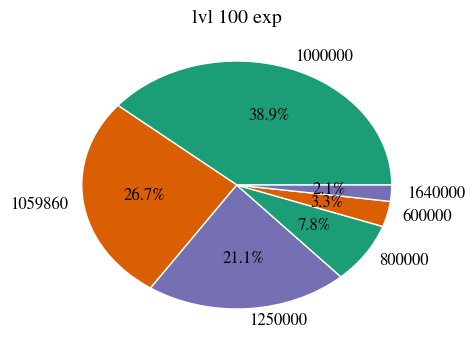

In [13]:
pokemon['lvl_100_exp'].value_counts().plot(kind='pie', label=' ', autopct='%1.1f%%', colors = dark2_colors[0:3]);
plt.title('lvl 100 exp');

Доля самых опытных покемонов составила 2,1% выборки, к наименее опытным относится чуть больше - 3,3%, при этом опыт большинства покемонов - 38,9%, составляет 1 000 000.

А теперь, для того чтобы лучше изучить структуру данных и выявить некоторые закономерности, построим дерево принятия решений, которое будет прогнозировать уровень счастья покемонов в зависимости от их остальных характеристик.

## Построение дерева принятия решений

Для начала разделим выборку на показатель, который мы исследуем ('base_happiness'), и признаки, его определяющие:

In [14]:
y = pokemon['base_happiness']
pokemon = pokemon.drop(['base_happiness', 'id'], axis=1)

Выделим 70% выборки (X_train, y_train) под обучение и 30% для проведения тестов на оценку точности прогноза (X_test, y_test). Критерием качества разбиения в задаче классификации был выбран коэффициент Джини (Gini impurity): $$ G=1-\sum_{i=1}^{n}p{_{i}}^{2} $$ где $p{_{i}}$ - частоты появления представителей одного и того же класса в листе дерева. Минимальное значение коэффициента достигается в нуле и означает, что все элементы подмножества принадлежат одному и тому же классу. Для построения дерева необходимо указать максимальную глубину и максимальное количество характеристик, используемое на каждом разбиении. Наиболее подходящие параметры лишь предстоит выяснить, поэтому пока просто укажем max_depth=5 и max_features=10. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(pokemon.values, y, test_size=0.3, random_state=15) 

tree = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features=10, random_state=15)
tree.fit(X_train, y_train);

На основе построенной модели сделаем прогноз. Для оценки качества предсказаний определим долю правильных ответов:

In [16]:
tree_pred = tree.predict(X_test) 
accuracy_score(y_test, tree_pred) 

0.87939698492462315

Проведём кросс-валидацию, чтобы определить сочетание параметров, которое даст наилучший результат:

In [17]:
tree_params = {'max_depth': range(1,10),
'max_features': range(2, 17)}
tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True) 

tree_grid.fit(X_train, y_train);

tree_grid.best_score_, tree_grid.best_params_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:    2.2s finished


(0.91379310344827591, {'max_depth': 7, 'max_features': 7})

На кросс-валидации доля правильных ответов возросла до 91,38%. Оценим точность прогноза при использовании отобранных парметров на тестовой выборке:

In [18]:
accuracy_score(y_test, tree_grid.predict(X_test))

0.90452261306532666

Можно отметить небольшое снижение показателя. А теперь посмотрим, что у нас получилось:

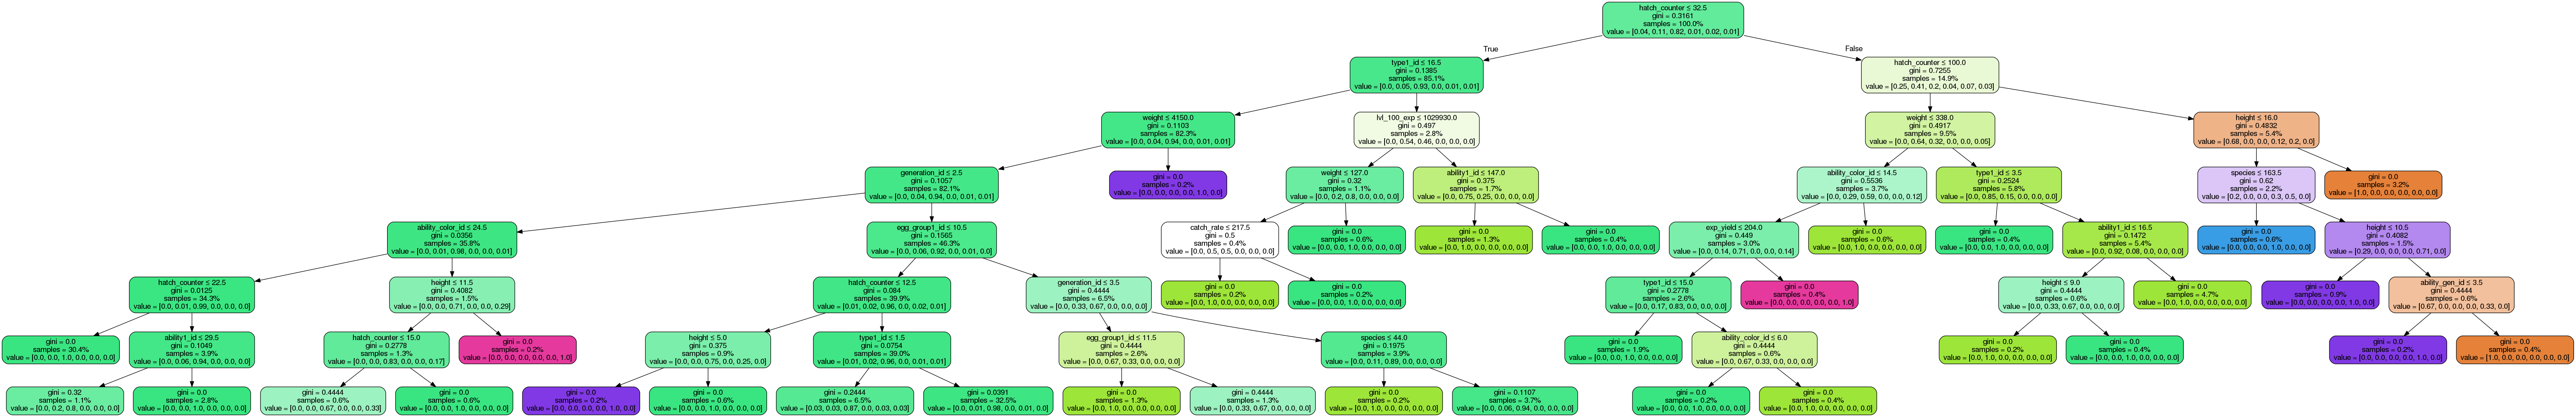

In [19]:
from sklearn import tree
dot_data = tree.export_graphviz(tree_grid.best_estimator_, feature_names=pokemon.columns, out_file=None, 
                                filled=True, proportion=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

"Гуляя" по дереву, можно сделать несколько интересных выводов. Например, для того чтобы почувствовать себя одним из самых несчастных (base_happiness = 0), покемону нужно чтобы характеризующий его признак hatch_counter превышал значение, равное 100, при этом его рост должен быть больше 16, хотя некоторые виды покемонов (species > 163) чувствуют себя несчастными и при меньшем росте (но не ниже 10!), и только при условии, что они обладают способностью поколения 4 и выше. Принадлежность к одному из оставшихся видов покемонов (species <= 163) и выполнении перечисленных ранее условий гарантирует покемону базовый уровень счастья = 90, что гораздо выше нулевого. К сожалению, выяснение причин подобного явления осталось за рамками данного исследования. Дальнейшие попытки интерпретации приводят к гораздо менее увлекательным выводам, поэтому на этом мы закончим.

## Random Forest

Попробуем выяснить, насколько использование алгоритма случайного леса позволит улучшить результаты.

In [20]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1, random_state=15)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.900767807586


Без настройки алгоритм Random Forest показал результат на 2,14% лучше, чем дерево решений со случайно выбранными параметрами.

In [21]:
forest_params = {'max_depth': range(1,15),
'max_features': range(1,16)}


forest_grid = GridSearchCV(forest, forest_params,
cv=5, n_jobs=-1,
verbose=True)


forest_grid.fit(X_train, y_train)


forest_grid.best_params_, forest_grid.best_score_

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 11.0min finished


({'max_depth': 10, 'max_features': 13}, 0.92241379310344829)

In [22]:
accuracy_score(y_test, forest_grid.predict(X_test))

0.9346733668341709

После настройки параметров прогноз, полученный с помощью применения алгоритма случайного леса, оказался на 0,86% точнее на кросс-валидации, и на 3% - при тестировании на отложенной выборке, в сравнении с деревом принятия решений. Однако, стоит отметить, что на построение модели ушло намного больше времени. 